# Imports


In [1]:
!pip install ptflops
!pip install codecarbon

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import gc
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from tqdm import tqdm
from torchvision import datasets
from torchvision import transforms

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, ConcatDataset

from collections import Counter
from codecarbon import EmissionsTracker

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train, Test, Validation

In [3]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Images Regularization
    transform_original = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    # Image Augmentation
    transform_aug = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2,
                               saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        normalize,
        transforms.RandomErasing(p=0.1)
    ])

    if test:
        dataset = datasets.CIFAR10(
            root=data_dir, train=False,
            download=True, transform=transform_original
        )

        return DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

    # Regular Dataset
    train_dataset_orig = datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform_original
    )

    # Augmented Dataset
    train_dataset_aug = datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform_aug
    )


    # Unify the training sets and separate their data from the validation set
    num_train = len(train_dataset_orig)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]


    train_dataset = ConcatDataset([
        torch.utils.data.Subset(train_dataset_orig, train_idx),
        torch.utils.data.Subset(train_dataset_aug, train_idx)
    ])

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
    )

    valid_dataset = torch.utils.data.Subset(train_dataset_orig, valid_idx)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )

    return train_loader, valid_loader

# ResNet Architecture

### The backbone consists of blocks of convolutional layers and residual connections.

### Regarding ResNet18 and ResNet34 variants each block consists of pairs of convolutional layers and the residual connection to the next block.

### For example, ResNet18 consists of 4 layers and each one contains 2 blocks. Therefore, there are 16 convolutional layers apart from the initial convolutional layer and the final fully connected layer. This is the visual representation of the aforementioned example.

</br>

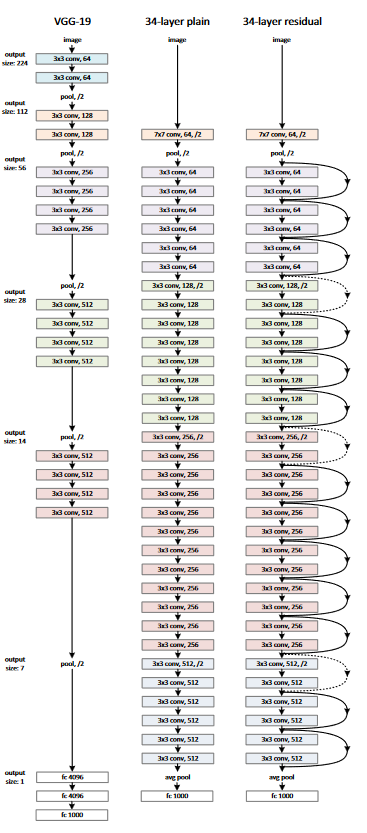

### There are various differences between ResNet18, ResNet34 and ResNet50. One of the most significant is that ResNet50 consists of blocks of three convolutional layers each, with varying number of filters.

### The image can be found here: https://www.digitalocean.com/community/tutorials/writing-resnet-from-scratch-in-pytorch

# Residual Blocks

## ResNet18 & ResNet34 Residual Block

In [4]:
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU())
    self.conv2 = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                nn.BatchNorm2d(out_channels))
    self.downsample = downsample
    self.relu = nn.ReLU()
    self.out_channels = out_channels

  def forward(self, x):
      residual = x
      out = self.conv1(x)
      out = self.conv2(out)
      if self.downsample:
        residual = self.downsample(x)
      out += residual
      out = self.relu(out)
      return out

## ResNet50 Residual Block

In [5]:
class ResidualBlock50(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock50, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

# Backbones

## ResNet18 & ResNet34

In [6]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 10):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

## ResNet50

In [7]:
class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet50, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer0 = self._make_layer(block, 64, layers[0])
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # better than fixed 7x7
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Backbone Training + Validation + Testing

### Its worth mentioning that during the training the batch size is 64 and that during the inference the batch size is 1.

### We want to be able to compare the outputs of Early-Exiting models and normal models on equal terms.

In [8]:
def training(layers, itsfifty=False, variant=None):

  # Create dataloaders
  train_loader, valid_loader = data_loader(data_dir='./data',
                                             batch_size=64)
  test_loader = data_loader(data_dir='./data',
                                  batch_size=1,
                                  test=True)

  # Model Initialization
  if itsfifty:
    model = ResNet50(ResidualBlock50, layers).to(device)
  else:
    model = ResNet(ResidualBlock, layers).to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)

  total_step = len(train_loader)

  start = time.time()

  scaler = torch.cuda.amp.GradScaler()

  num_epochs = 20

  for epoch in range(num_epochs):
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

  end = time.time()

  print(f"Elapsed time: {end - start:.4f} seconds")


  # Validation
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

  # Save the model
  if variant != None:
    variant = str(variant)
    torch.save(model.state_dict(), "/content/data/model_weights_resnet" + str(variant) + ".pth")
    print("Saved with success")


def testing(model, early=False):

  test_loader = data_loader(data_dir='./data',
                                  batch_size=1,
                                  test=True)

  if early == True:
    start = time.time()

    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds, exits = model(images)

        predicted = preds.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f"Accuracy of the network on the {total} test images: {accuracy:.2f} %")

    end = time.time()
    print(f"Elapsed time: {end - start:.4f} seconds")
    return

  start = time.time()

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

  end = time.time()

  print(f"Elapsed time: {end - start:.4f} seconds")

  return 100 * correct / total, end-start

## ResNet18 Training + Testing

In [ ]:
training([2,2,2,2], variant=18)

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

state_dict = torch.load("/content/data/model_weights_resnet18.pth")
model.load_state_dict(state_dict)
model.eval()

testing(model)

## ResNet34 Training + Testing

In [ ]:
training([3,4,6,3], variant=34)

In [ ]:
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

state_dict = torch.load("/content/data/model_weights_resnet34.pth")
model.load_state_dict(state_dict)
model.eval()

testing(model)

## ResNet50 Training + Testing

In [ ]:
training([3,4,6,3], itsfifty=True, variant=50)

/tmp/ipython-input-1148772567.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/20:   0%|          | 0/1407 [00:00<?, ?it/s]/tmp/ipython-input-1148772567.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/20: 100%|██████████| 1407/1407 [04:30<00:00,  5.20it/s, loss=0.0371]

Elapsed time: 5419.2888 seconds


Accuracy of the network on the 5000 validation images: 89.26 %
Saved with success


In [ ]:
model = ResNet50(ResidualBlock50, [3, 4, 6, 3]).to(device)

state_dict = torch.load("/content/data/model_weights_resnet50.pth")
model.load_state_dict(state_dict)
model.eval()

testing(model)

Accuracy of the network on the 10000 test images: 89.18 %
Elapsed time: 79.4158 seconds


# Early Exiting Variants

### We introduce branches of varying depth across the models. Based on the BranchyNet paper we choose to assign more complex branches to the shallow layers.

### The branches of ResNet50 are more complex because we assume that the attached branches should correspond to the model's backbone layers.


## Exit Blocks (Branches)


In [9]:
class ExitBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_convs=1):
        super(ExitBlock, self).__init__()
        layers = []
        channels = in_channels

        for _ in range(num_convs):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU(inplace=True))

        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

In [10]:
class ExitBlock50(nn.Module):
    def __init__(self, in_channels, num_classes, num_convs=1, reduction=0.25):
        super(ExitBlock50, self).__init__()

        reduced_channels = max(16, int(in_channels * reduction))  # shrink channels
        layers = [nn.Conv2d(in_channels, reduced_channels, kernel_size=1),  # bottleneck
                  nn.BatchNorm2d(reduced_channels),
                  nn.ReLU(inplace=True)]

        for _ in range(num_convs):
            layers.append(nn.Conv2d(reduced_channels, reduced_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(reduced_channels))
            layers.append(nn.ReLU(inplace=True))

        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(reduced_channels, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

## Early-Exit Architecture

### ResNet34 & ResNet18

In [11]:
class ResNetEE(nn.Module):
    def __init__(self, block, layers, num_classes=10, confidence_threshold=0.9):
        super(ResNetEE, self).__init__()
        self.inplanes = 64
        self.confidence_threshold = confidence_threshold

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        self.exit0 = ExitBlock(64, num_classes, num_convs=3)
        self.exit1 = ExitBlock(128, num_classes, num_convs=2)
        self.exit2 = ExitBlock(256, num_classes, num_convs=1)
        self.exit3 = ExitBlock(512, num_classes, num_convs=1)

        self.early_exits = [self.exit0, self.exit1, self.exit2, self.exit3]
        self.layers = [self.layer0, self.layer1, self.layer2, self.layer3]

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, exit_layer=None):
        if self.training:
            x = self.conv1(x)
            x = self.maxpool(x)

            x0 = self.layer0(x)
            out0 = self.exit0(x0)

            x1 = self.layer1(x0)
            out1 = self.exit1(x1)

            x2 = self.layer2(x1)
            out2 = self.exit2(x2)

            x3 = self.layer3(x2)
            out3 = self.exit3(x3)

            xf = self.avgpool(x3)
            xf = torch.flatten(xf, 1)
            out_final = self.fc(xf)

            return [out0, out1, out2, out3, out_final]

        else:

          x = self.conv1(x)
          x = self.maxpool(x)
          x = self.layer0(x)
          out0 = self.exit0(x)
          if self._confident_enough(out0):
            return out0, 0

          x = self.layer1(x)
          out1 = self.exit1(x)
          if self._confident_enough(out1):
            return out1, 1

          x = self.layer2(x)
          out2 = self.exit2(x)
          if self._confident_enough(out2):
            return out2, 2

          x = self.layer3(x)
          out3 = self.exit3(x)
          if self._confident_enough(out3):
            return out3, 3

          xf = self.avgpool(x)
          xf = torch.flatten(xf, 1)
          out_final = self.fc(xf)
          return out_final, 4

    def _confident_enough(self, logits):
        probs = F.softmax(logits, dim=1)
        conf, _ = probs.max(dim=1)
        return conf.item() >= self.confidence_threshold

### ResNet50

In [12]:
class ResNetEE50(nn.Module):
    def __init__(self, block, layers, num_classes=10, confidence_threshold=0.9):
        super(ResNetEE50, self).__init__()
        self.inplanes = 64
        self.confidence_threshold = confidence_threshold

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.exit0 = ExitBlock50(64 * block.expansion, num_classes, num_convs=3)
        self.exit1 = ExitBlock50(128 * block.expansion, num_classes, num_convs=2)
        self.exit2 = ExitBlock50(256 * block.expansion, num_classes, num_convs=1)
        self.exit3 = ExitBlock50(512 * block.expansion, num_classes, num_convs=1)

        self.early_exits = [self.exit0, self.exit1, self.exit2, self.exit3]
        self.layers = [self.layer0, self.layer1, self.layer2, self.layer3]

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, exit_layer=None):
        if self.training:
            x = self.conv1(x)
            x = self.maxpool(x)

            x0 = self.layer0(x)
            out0 = self.exit0(x0)

            x1 = self.layer1(x0)
            out1 = self.exit1(x1)

            x2 = self.layer2(x1)
            out2 = self.exit2(x2)

            x3 = self.layer3(x2)
            out3 = self.exit3(x3)

            xf = self.avgpool(x3)
            xf = torch.flatten(xf, 1)
            out_final = self.fc(xf)

            return [out0, out1, out2, out3, out_final]

        else:

          x = self.conv1(x)
          x = self.maxpool(x)
          x = self.layer0(x)
          out0 = self.exit0(x)
          if self._confident_enough(out0):
            return out0, 0

          x = self.layer1(x)
          out1 = self.exit1(x)
          if self._confident_enough(out1):
            return out1, 1

          x = self.layer2(x)
          out2 = self.exit2(x)
          if self._confident_enough(out2):
            return out2, 2

          x = self.layer3(x)
          out3 = self.exit3(x)
          if self._confident_enough(out3):
            return out3, 3

          xf = self.avgpool(x)
          xf = torch.flatten(xf, 1)
          out_final = self.fc(xf)
          return out_final, 4

    def _confident_enough(self, logits):
        probs = F.softmax(logits, dim=1)
        conf, _ = probs.max(dim=1)
        return conf.item() >= self.confidence_threshold

## Early-Exit Training + Validation + Testing

In [13]:
def trainingEE(layers, itsfifty=False, variant=None):

  num_epochs = 20

  # Create dataloaders
  train_loader, valid_loader = data_loader(data_dir='./data',
                                             batch_size=64)

  if itsfifty:
    model = ResNetEE50(ResidualBlock50, layers).to(device)
  else:
    model = ResNetEE(ResidualBlock, layers).to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  # Train the model
  total_step = len(train_loader)

  loss_weights = [0.9, 0.9, 0.8, 0.7, 0.3]
  criterion = nn.CrossEntropyLoss()

  total_step = len(train_loader)
  scaler = torch.cuda.amp.GradScaler()

  start = time.time()

  for epoch in range(num_epochs):
    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            outputs = model(images)

            losses = [criterion(o, labels) for o in outputs]
            total_loss = sum(w * l for w, l in zip(loss_weights, losses))

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=total_loss.item())

  end = time.time()
  print(f"Elapsed time: {end - start:.4f} seconds")

  # Save the model
  if variant != None:
    variant = str(variant)
    torch.save(model.state_dict(), "/content/data/model_weights_resnet" + str(variant) + "_EE.pth")
    print("Saved with success")

### ResNet18 Training + Testing

In [ ]:
trainingEE([2,2,2,2], variant=18)

/tmp/ipython-input-3827519457.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/20:   0%|          | 0/1407 [00:00<?, ?it/s]/tmp/ipython-input-3827519457.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/20: 100%|██████████| 1407/1407 [02:01<00:00, 11.55it/s, loss=0.67]


Elapsed time: 2427.4480 seconds
Saved with success


In [ ]:
model = ResNetEE(ResidualBlock, [2, 2, 2, 2]).to(device)

state_dict = torch.load("/content/data/model_weights_resnet18_EE.pth")
model.load_state_dict(state_dict)
model.eval()

testing(model, early=True)

Accuracy of the network on the 10000 test images: 90.00 %
Elapsed time: 36.2740 seconds


### ResNet34 Training + Testing

In [ ]:
trainingEE([3,4,6,3], variant=34)

/tmp/ipython-input-3827519457.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/20:   0%|          | 0/1407 [00:00<?, ?it/s]/tmp/ipython-input-3827519457.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/20: 100%|██████████| 1407/1407 [02:41<00:00,  8.69it/s, loss=1.07]


Elapsed time: 3244.7236 seconds
Saved with success


In [ ]:
model = ResNetEE(ResidualBlock, [3, 4, 6, 3]).to(device)

state_dict = torch.load("/content/data/model_weights_resnet34_EE.pth")
model.load_state_dict(state_dict)
model.eval()

testing(model, early=True)

Accuracy of the network on the 10000 test images: 90.48 %
Elapsed time: 41.9912 seconds


### ResNet50 Training + Testing

In [ ]:
trainingEE([3,4,6,3], variant=50, itsfifty=True)

/tmp/ipython-input-3279215765.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/20:   0%|          | 0/1407 [00:00<?, ?it/s]/tmp/ipython-input-3279215765.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20/20: 100%|██████████| 1407/1407 [05:17<00:00,  4.44it/s, loss=0.861]


Elapsed time: 6339.0952 seconds
Saved with success


In [ ]:
model = ResNetEE50(ResidualBlock50, [3, 4, 6, 3]).to(device)

state_dict = torch.load("/content/data/model_weights_resnet502_EE.pth")
model.load_state_dict(state_dict)
model.eval()

testing(model, early=True)

Accuracy of the network on the 10000 test images: 90.04 %
Elapsed time: 53.9802 seconds


# Average FLOPs per sample estimation

### To effectively compute the average FLOPs per sample regarding the EE models we need to store the FLOPs per exit.

### To this end we are trying to utilize a wrapper class.

In [14]:
class ResNetExitWrapper(nn.Module):
    def __init__(self, original_model, exit_idx):
        super().__init__()
        self.model = original_model
        self.exit_idx = exit_idx

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.maxpool(x)

        layers = [self.model.layer0, self.model.layer1, self.model.layer2, self.model.layer3]
        exits = [self.model.exit0, self.model.exit1, self.model.exit2, self.model.exit3]

        for i, layer in enumerate(layers):
            x = layer(x)
            if i == self.exit_idx and self.exit_idx < 4:
                return exits[i](x)

        # final layer
        if self.exit_idx == 4:
            x = self.model.avgpool(x)
            x = torch.flatten(x, 1)
            return self.model.fc(x)

In [15]:
from ptflops import get_model_complexity_info

def FLOPs(model, early=False):
  if not early:
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=False, print_per_layer_stat=False)
    flops = macs * 2
    return flops

  else:
    flops_by_exit = {}

    for exit_idx in range(5):
      wrapper = ResNetExitWrapper(model, exit_idx).to('cuda')
      macs, params = get_model_complexity_info(wrapper, (3, 224, 224), as_strings=False, print_per_layer_stat=False)
      flops_by_exit[exit_idx] = macs * 2

    return flops_by_exit



In [16]:
def avg_FLOPs(flops, model, test_loader):
  total_flops = 0
  total_samples = 0

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds, exit = model(images)
        predicted = preds.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        total_flops += flops[int(exit)]
        total_samples += 1

  avg_flops = total_flops / total_samples

  return avg_flops

# Average Energy Consumption and CO2 Emissions

In [17]:
def consumption(model, test_loader):
    tracker = EmissionsTracker(project_name="resnet_eval")
    tracker.start()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            if isinstance(output, tuple):
                preds, exit_id = output
            else:
                preds = output

            predicted = preds.argmax(dim=1)

    emissions = tracker.stop()

    energy_data = tracker.final_emissions_data
    energy_consumed = energy_data.energy_consumed
    gpu_energy_consumed = energy_data.gpu_energy
    gpu_model = energy_data.gpu_model
    emiss = energy_data.emissions

    return energy_consumed, gpu_energy_consumed, gpu_model, emiss

# Exit distribution

In [18]:
def exits(model, test_loader):
    exit_counter = Counter()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds, exit_id = model(images)
            predicted = preds.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            exit_counter[int(exit_id)] += 1

    return exit_counter

# Accuracy -  Inference Time

In [19]:
def performance_metrics(model, early=False):

  test_loader = data_loader(data_dir='./data',
                                  batch_size=1,
                                  test=True)

  if early == True:
    start = time.time()

    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds, exits = model(images)

        predicted = preds.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    end = time.time()

    return 100 * correct / total, end-start

  start = time.time()

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  end = time.time()

  return 100 * correct / total, end-start

# Diagrams

## The following block of code iterates through all of our models and provides insights on their inference time, exiting behavior, performance metrics and energy efficiency

## Summarize

### We need to extract a summary of our models metrics

In [20]:
test_loader = data_loader(data_dir='./data',
                                  batch_size=1,
                                  test=True)

path = "/content/data"


def summarize(test_loader, path):
  results = []

  for filename in os.listdir(path):
    if filename.endswith(".pth") and "_EE" in filename:
        if "50" in filename:
            model = ResNetEE50(ResidualBlock50, [3, 4, 6, 3]).to(device)
            name = "ResNet50_EE"
        elif "34" in filename:
            model = ResNetEE(ResidualBlock, [3, 4, 6, 3]).to(device)
            name = "ResNet34_EE"
        else:
            model = ResNetEE(ResidualBlock, [2, 2, 2, 2]).to(device)
            name = "ResNet18_EE"

        state_dict = torch.load(os.path.join(path, filename))
        model.load_state_dict(state_dict)
        model.eval()

        accuracy, inference_time = performance_metrics(model, early=True)
        exit_counts = exits(model, test_loader)
        flops = FLOPs(model, early=True)
        avg_flops = avg_FLOPs(flops, model, test_loader)
        energy_consumed, gpu_energy_consumed, gpu_model, emi = consumption(model, test_loader)

        results.append({
            "Model": name,
            "Accuracy": accuracy,
            "Inference_Time": inference_time,
            "Exits": dict(exit_counts),
            "FLOPs_by_exit": flops,
            "Avg_FLOPs_per_sample": avg_flops,
            "Energy_Consumed": energy_consumed,
            "GPU_Energy_Consumed": gpu_energy_consumed,
            "GPU_Model": gpu_model,
            "Emissions": emi
        })

    elif filename.endswith(".pth") and "_EE" not in filename:
        if "50" in filename:
            model = ResNet50(ResidualBlock50, [3, 4, 6, 3]).to(device)
            name = "ResNet50"
        elif "34" in filename:
            model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
            name = "ResNet34"
        else:
            model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
            name = "ResNet18"

        state_dict = torch.load(os.path.join(path, filename))
        model.load_state_dict(state_dict)
        model.eval()

        accuracy, inference_time = performance_metrics(model, early=False)
        flops = FLOPs(model)
        energy_consumed, gpu_energy_consumed, gpu_model, emi = consumption(model, test_loader)

        results.append({
            "Model": name,
            "Accuracy": accuracy,
            "Inference_Time": inference_time,
            "Exits": None,
            "FLOPs_by_exit": None,
            "Avg_FLOPs_per_sample": flops,
            "Energy_Consumed": energy_consumed,
            "GPU_Energy_Consumed": gpu_energy_consumed,
            "GPU_Model": gpu_model,
            "Emissions": emi
        })

  # Sort results by model name to ensure desired order
  sorted_results = sorted(results, key=lambda x: (x['Model'].replace('ResNet', '').replace('_EE', '')))

  df = pd.DataFrame(sorted_results)

  print(df)

  df.to_csv("model_results_A100.csv", index=False)

  return

100%|██████████| 170M/170M [00:03<00:00, 54.3MB/s]


In [21]:
summarize(test_loader, path)

[codecarbon WARNING @ 14:03:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:03:11] [setup] RAM Tracking...
[codecarbon INFO @ 14:03:11] [setup] CPU Tracking...
[codecarbon WARNING @ 14:03:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:03:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:03:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 14:03:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:03:12] [setup] GPU Tracking...
[codecarbon INFO @ 14:03:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:03:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

         Model  Accuracy  Inference_Time  \
0  ResNet18_EE     90.00       38.494574   
1     ResNet18     90.02       43.015947   
2     ResNet34     89.79       65.868862   
3  ResNet34_EE     90.48       41.891078   
4     ResNet50     89.20       78.855508   
5  ResNet50_EE     90.04       52.575870   

                                         Exits  \
0  {0: 5123, 1: 2780, 2: 1106, 4: 658, 3: 333}   
1                                         None   
2                                         None   
3   {0: 5757, 1: 2619, 2: 839, 4: 630, 3: 155}   
4                                         None   
5  {0: 4962, 1: 2606, 2: 1475, 3: 226, 4: 731}   

                                       FLOPs_by_exit  Avg_FLOPs_per_sample  \
0  {0: 1880196372, 1: 2471471636, 2: 3063049236, ...          2.358942e+09   
1                                               None          3.654579e+09   
2                                               None          7.366499e+09   
3  {0: 2346632468, 1: 386676

## Exits Diagram

In [ ]:
data = pd.read_csv("/content/model_results.csv")
exit_data = []

for _, row in data.iterrows():
    if row["Exits"] is not None and pd.notna(row["Exits"]):
        exit_dict = ast.literal_eval(row["Exits"])
        for exit_id, count in exit_dict.items():
            exit_data.append({
                "Model": row["Model"],
                "Exit": exit_id,
                "Samples": count
            })

exit_df = pd.DataFrame(exit_data)

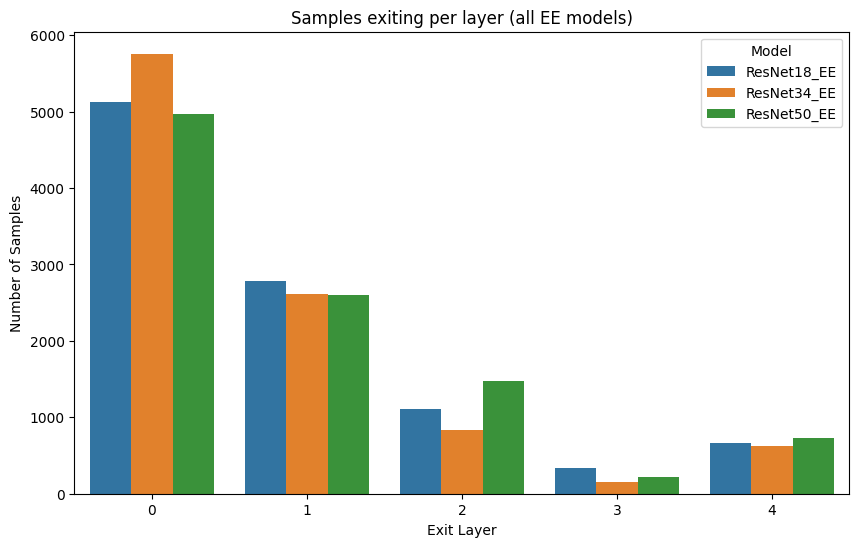

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=exit_df, x="Exit", y="Samples", hue="Model")
plt.title("Samples exiting per layer (all EE models)")
plt.xlabel("Exit Layer")
plt.ylabel("Number of Samples")
plt.legend(title="Model")
plt.show()

## FLOPs Diagrams

In [ ]:
data = pd.read_csv("/content/model_results.csv")
flops_data = []

for _, row in data.iterrows():
    if row["FLOPs_by_exit"] is not None and pd.notna(row["FLOPs_by_exit"]):
        flops_dict = ast.literal_eval(row["FLOPs_by_exit"])
        for flops_id, count in flops_dict.items():
            flops_data.append({
                "Model": row["Model"],
                "Exit": flops_id,
                "Samples": count
            })

flops_df = pd.DataFrame(flops_data)

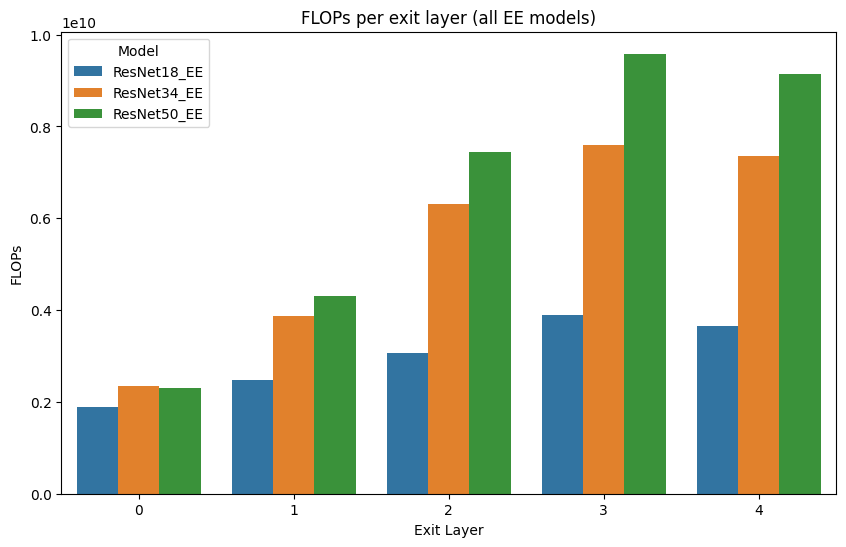

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=flops_df, x="Exit", y="Samples", hue="Model")
plt.title("FLOPs per exit layer (all EE models)")
plt.xlabel("Exit Layer")
plt.ylabel("FLOPs")
plt.legend(title="Model")
plt.show()

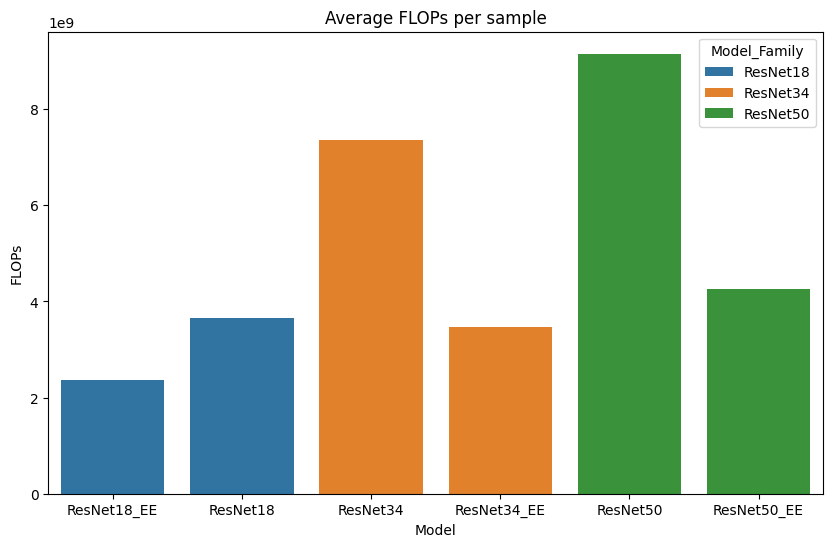

In [ ]:

data = pd.read_csv("/content/model_results.csv")

def classify_model(name):
    if "ResNet18" in name:
        return "ResNet18"
    elif "ResNet34" in name:
        return "ResNet34"
    else:
        return "ResNet50"

data["Model_Family"] = data["Model"].map(classify_model)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="Avg_FLOPs_per_sample", hue="Model_Family")
plt.title("Average FLOPs per sample")
plt.xlabel("Model")
plt.ylabel("FLOPs")
plt.show()

## Inference Time Diagrams

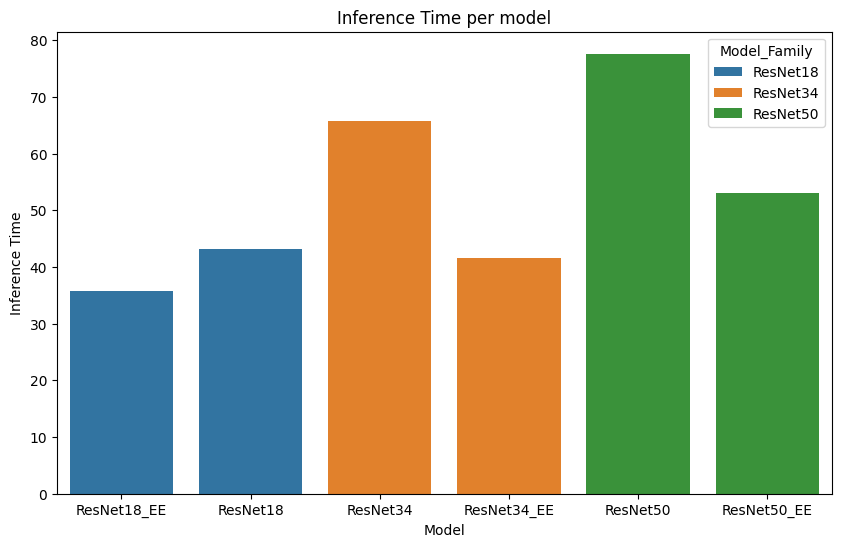

In [ ]:
data = pd.read_csv("/content/model_results.csv")

def classify_model(name):
    if "ResNet18" in name:
        return "ResNet18"
    elif "ResNet34" in name:
        return "ResNet34"
    else:
        return "ResNet50"

data["Model_Family"] = data["Model"].map(classify_model)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="Inference_Time", hue='Model_Family')
plt.title("Inference Time per model")
plt.xlabel("Model")
plt.ylabel("Inference Time")
plt.show()

## Accuracy Metrics

In [ ]:
df = data[['Model', 'Accuracy']]

In [ ]:
df

,Model,Accuracy
0,ResNet18_EE,90.00
1,ResNet18,90.02
2,ResNet34,89.79
3,ResNet34_EE,90.48
4,ResNet50,89.18
5,ResNet50_EE,90.04


## Consumption Diagrams

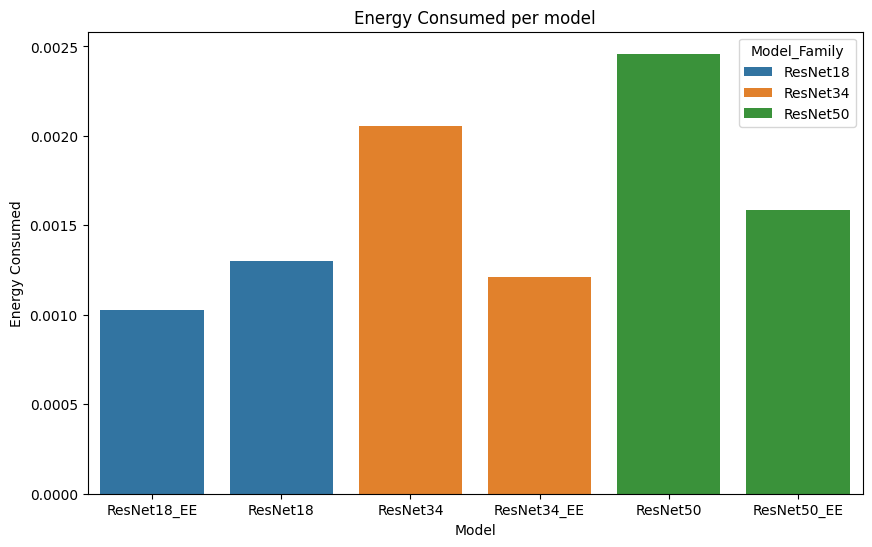

In [ ]:
data = pd.read_csv("/content/model_results.csv")

def classify_model(name):
    if "ResNet18" in name:
        return "ResNet18"
    elif "ResNet34" in name:
        return "ResNet34"
    else:
        return "ResNet50"

data["Model_Family"] = data["Model"].map(classify_model)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="Energy_Consumed", hue='Model_Family')
plt.title("Energy Consumed per model")
plt.xlabel("Model")
plt.ylabel("Energy Consumed")
plt.show()

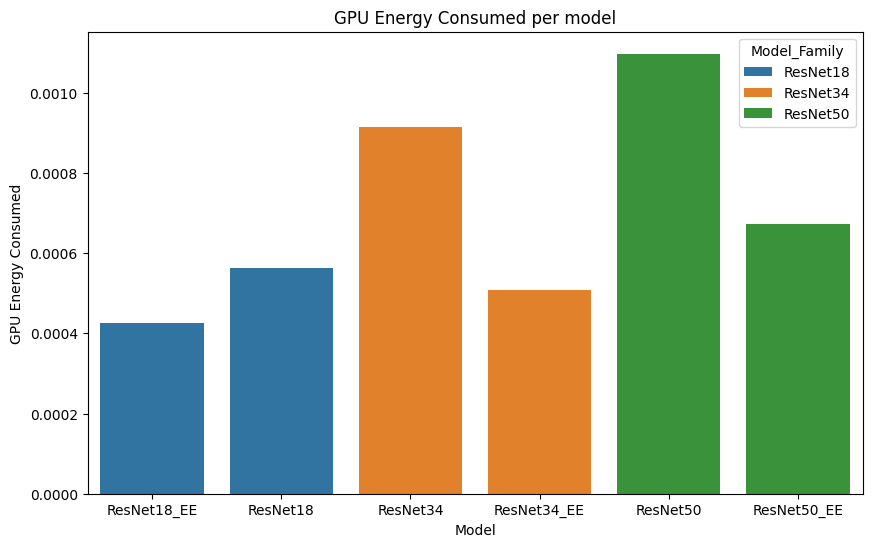

In [ ]:
data = pd.read_csv("/content/model_results.csv")

def classify_model(name):
    if "ResNet18" in name:
        return "ResNet18"
    elif "ResNet34" in name:
        return "ResNet34"
    else:
        return "ResNet50"

data["Model_Family"] = data["Model"].map(classify_model)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="GPU_Energy_Consumed", hue='Model_Family')
plt.title("GPU Energy Consumed per model")
plt.xlabel("Model")
plt.ylabel("GPU Energy Consumed")
plt.show()

## Energy Consumption Comparison between GPUs

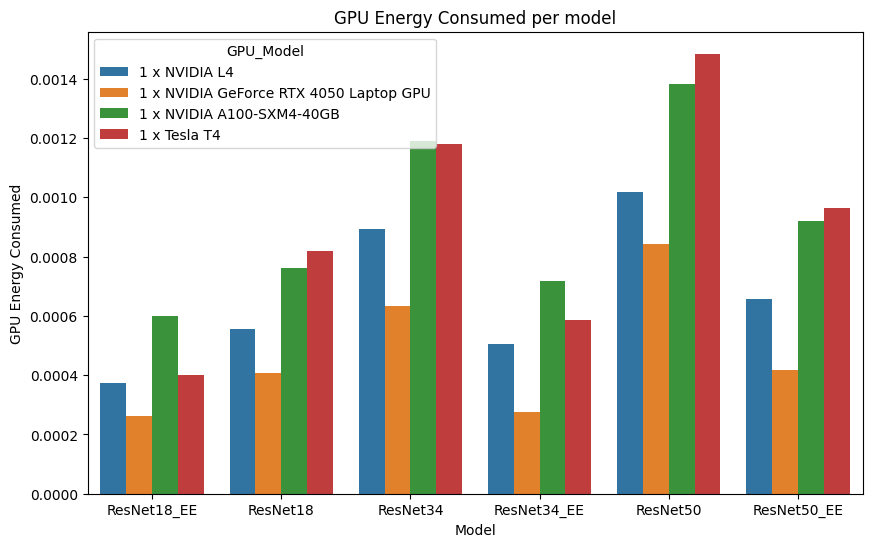

In [22]:
data = pd.read_csv("/content/model_results_L4.csv")
data1 = pd.read_csv("/content/model_results_RTX4050.csv")
data2 = pd.read_csv("/content/model_results_A100.csv")
data3 = pd.read_csv("/content/model_results_T4.csv")

data = pd.concat([data, data1, data2, data3], ignore_index=True)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="GPU_Energy_Consumed", hue='GPU_Model')
plt.title("GPU Energy Consumed per model")
plt.xlabel("Model")
plt.ylabel("GPU Energy Consumed")
plt.show()

## Inference Time Comparison between GPUs

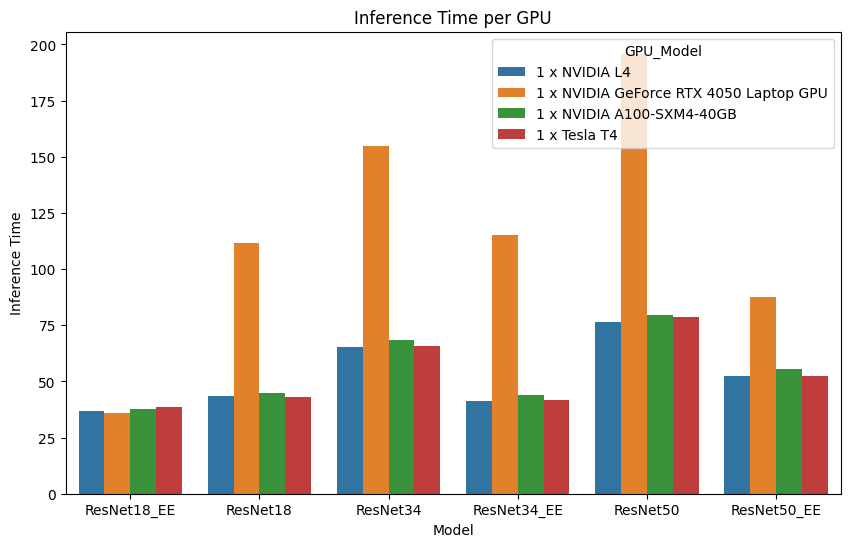

In [23]:
data = pd.read_csv("/content/model_results_L4.csv")
data1 = pd.read_csv("/content/model_results_RTX4050.csv")
data2 = pd.read_csv("/content/model_results_A100.csv")
data3 = pd.read_csv("/content/model_results_T4.csv")

data = pd.concat([data, data1, data2, data3], ignore_index=True)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="Inference_Time", hue='GPU_Model')
plt.title("Inference Time per GPU")
plt.xlabel("Model")
plt.ylabel("Inference Time")
plt.show()

## Emissions Comparison

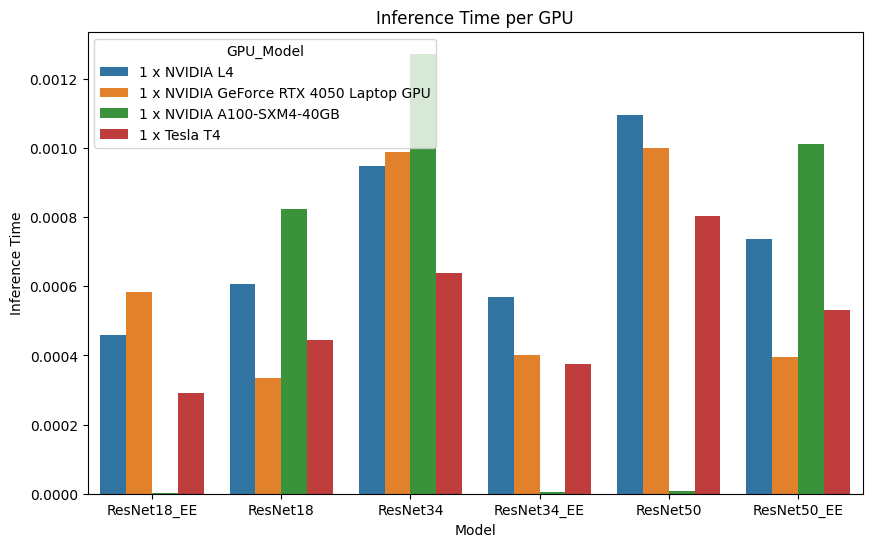

In [24]:
data = pd.read_csv("/content/model_results_L4.csv")
data1 = pd.read_csv("/content/model_results_RTX4050.csv")
data2 = pd.read_csv("/content/model_results_A100.csv")
data3 = pd.read_csv("/content/model_results_T4.csv")

data = pd.concat([data, data1, data2, data3], ignore_index=True)

plt.figure(figsize=(10,6))
sns.barplot(data=data, x="Model", y="Emissions", hue='GPU_Model')
plt.title("Inference Time per GPU")
plt.xlabel("Model")
plt.ylabel("Inference Time")
plt.show()